<a href="https://colab.research.google.com/github/FALima8/Calculo_Odds/blob/main/Odds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###IMPORTS

In [2]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

###CARREGAMENTO E TRATAMENTO DO DATASET

In [3]:
# Carregando o csv
df = pd.read_csv("https://raw.githubusercontent.com/xgabora/Club-Football-Match-Data-2000-2025/main/data/Matches.csv", low_memory=False)

# Lista de colunas que representam eventos pós-jogo, mercados não ultilizados no modelo e data e hora
colunas_nao_ultilizadas = [
    "MatchTime", "MatchDate",                        #Hora e data do jogo
    "FTHome", "FTAway", "FTResult",                  # Resultado final
    "HTHome", "HTAway", "HTResult",                  # Resultado do 1º tempo
    "HomeShots", "AwayShots",                        # Chutes totais
    "HomeTarget", "AwayTarget",                      # Chutes no alvo
    "HomeFouls", "AwayFouls",                        # Faltas
    "HomeCorners", "AwayCorners",                    # Escanteios
    "HomeYellow", "AwayYellow",                      # Cartões amarelos
    "HomeRed", "AwayRed",                             # Cartões vermelhos
    "Over25", "Under25", "MaxOver25", "MaxUnder25",  # Mercado de gols (over/under 2.5)
    "HandiSize", "HandiHome", "HandiAway",            # Mercado de handicap asiático
    "MaxHome", "MaxDraw", "MaxAway"
]


# Remover as colunas do DataFrame
df_reduzido = df.drop(columns=colunas_nao_ultilizadas, errors='ignore')
df_reduzido = df_reduzido.drop(columns=["C_LTH",	"C_LTA",	"C_VHD",	"C_VAD",	"C_HTB","C_PHB"])

In [ ]:
# Preencher HomeElo e AwayElo ausentes com a média por time
media_elo_home = df_reduzido.groupby("HomeTeam")["HomeElo"].mean()
df_reduzido["HomeElo"] = df_reduzido.apply(
    lambda row: media_elo_home[row["HomeTeam"]] if pd.isna(row["HomeElo"]) else row["HomeElo"], axis=1
)

media_elo_away = df_reduzido.groupby("AwayTeam")["AwayElo"].mean()
df_reduzido["AwayElo"] = df_reduzido.apply(
    lambda row: media_elo_away[row["AwayTeam"]] if pd.isna(row["AwayElo"]) else row["AwayElo"], axis=1
)

# Remover registros que ainda têm Elo ausente
df_reduzido = df_reduzido.dropna(subset=["HomeElo", "AwayElo"])

In [ ]:
# Remover registros com odds da Bet365 ou odds máximas ausentes
colunas_odds = ["OddHome", "OddDraw", "OddAway"]
df_reduzido = df_reduzido.dropna(subset=colunas_odds)

In [ ]:
# Remover linhas com valores ausentes nas colunas de forma
colunas_forma = ["Form3Home", "Form5Home", "Form3Away", "Form5Away"]
df_reduzido = df_reduzido.dropna(subset=colunas_forma)

In [ ]:
#Aplicando target enconding para times da casa, visitante e divisão, usando de base a média historica de odds
# Criar média de todas as odds (Home, Draw, Away) para codificação da Division
division_encoding = df_reduzido.groupby("Division")[["OddHome", "OddDraw", "OddAway"]].mean().mean(axis=1)

# Codificar Division
df_reduzido["Division"] = df_reduzido["Division"].map(division_encoding)
# Codificar HomeTeam com base na média de OddHome
home_encoding = df_reduzido.groupby("HomeTeam")["OddHome"].mean()
df_reduzido["HomeTeam"] = df_reduzido["HomeTeam"].map(home_encoding)

# Codificar AwayTeam com base na média de OddAway
away_encoding = df_reduzido.groupby("AwayTeam")["OddAway"].mean()
df_reduzido["AwayTeam"] = df_reduzido["AwayTeam"].map(away_encoding)

df_reduzido["HomeTeam"] = df_reduzido["HomeTeam"].astype(float)
df_reduzido["AwayTeam"] = df_reduzido["AwayTeam"].astype(float)
df_reduzido["Division"] = df_reduzido["Division"].astype(float)

In [4]:
# Selecionar colunas numéricas
numeric_cols = df_reduzido.select_dtypes(include='number').columns

# Estatísticas descritivas
stats_description = df_reduzido[numeric_cols].describe().T
print(stats_description)

              count         mean         std      min      25%       50%  \
HomeElo    141597.0  1533.118663  153.279601  1103.13  1424.87  1515.450   
AwayElo    141528.0  1533.165652  153.294511  1103.13  1424.93  1515.475   
Form3Home  229057.0     3.984628    2.377010     0.00     2.00     4.000   
Form5Home  229057.0     6.721606    3.257166     0.00     4.00     7.000   
Form3Away  229057.0     4.203482    2.393202     0.00     3.00     4.000   
Form5Away  229057.0     6.928241    3.269548     0.00     4.00     7.000   
OddHome    227527.0     2.461303    1.373112     0.00     1.75     2.150   
OddDraw    227527.0     3.611563    0.849323     1.29     3.21     3.400   
OddAway    227527.0     4.018925    2.647317     1.01     2.60     3.330   

                 75%      max  
HomeElo    1634.2400  2107.48  
AwayElo    1634.2225  2107.48  
Form3Home     6.0000     9.00  
Form5Home     9.0000    15.00  
Form3Away     6.0000     9.00  
Form5Away     9.0000    15.00  
OddHome       2

In [5]:
# Verificar valores ausentes
missing_summary = df_reduzido.isnull().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]
print(missing_summary)

AwayElo      89029
HomeElo      88960
OddAway       3030
OddDraw       3030
OddHome       3030
Form3Away     1500
Form3Home     1500
Form5Home     1500
Form5Away     1500
dtype: int64


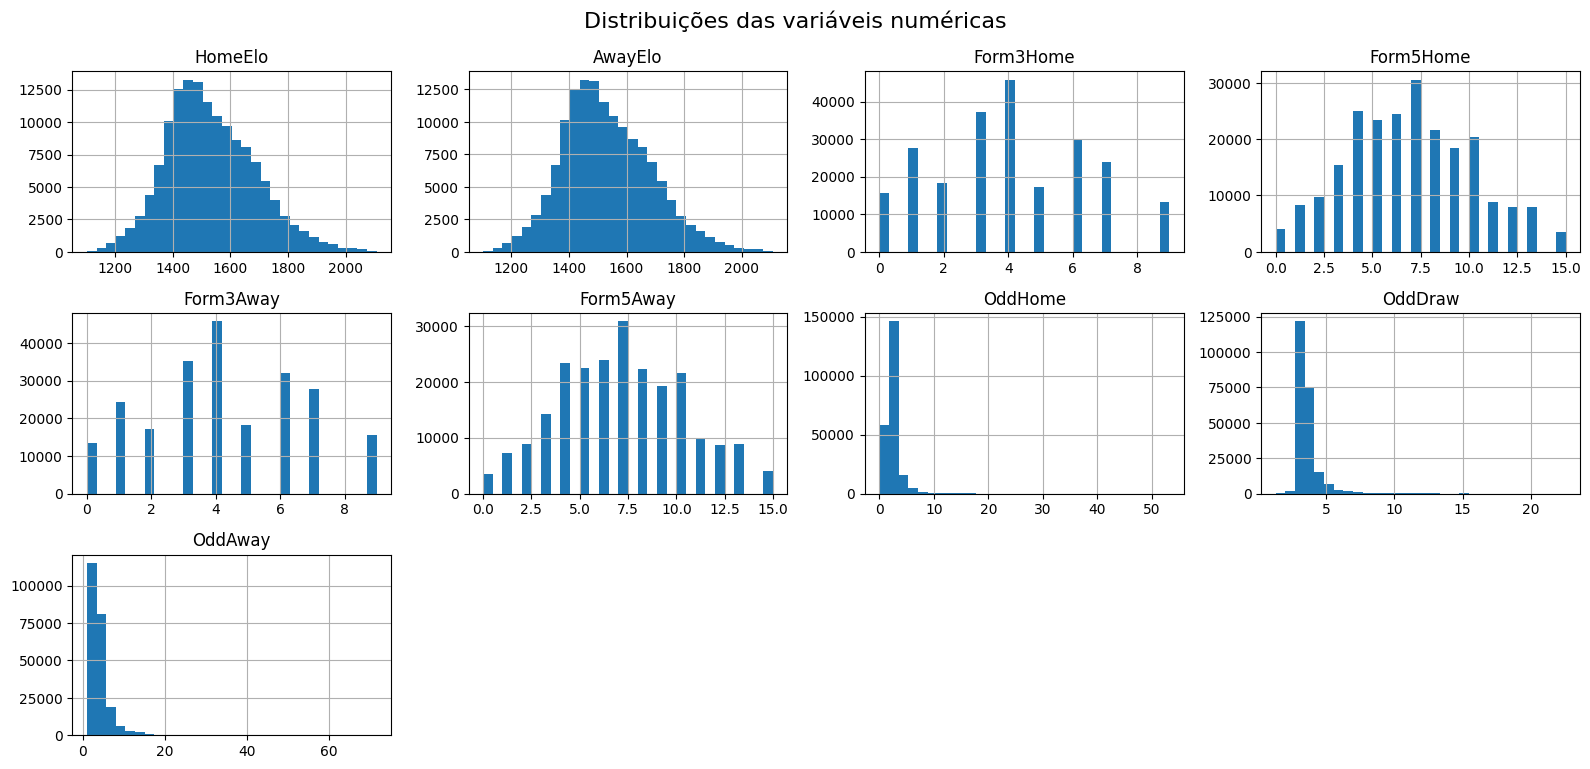

In [6]:
# Histogramas
df_reduzido[numeric_cols].hist(bins=30, figsize=(16, 12), layout=(5, 4))
plt.tight_layout()
plt.suptitle("Distribuições das variáveis numéricas", fontsize=16, y=1.02)
plt.show()

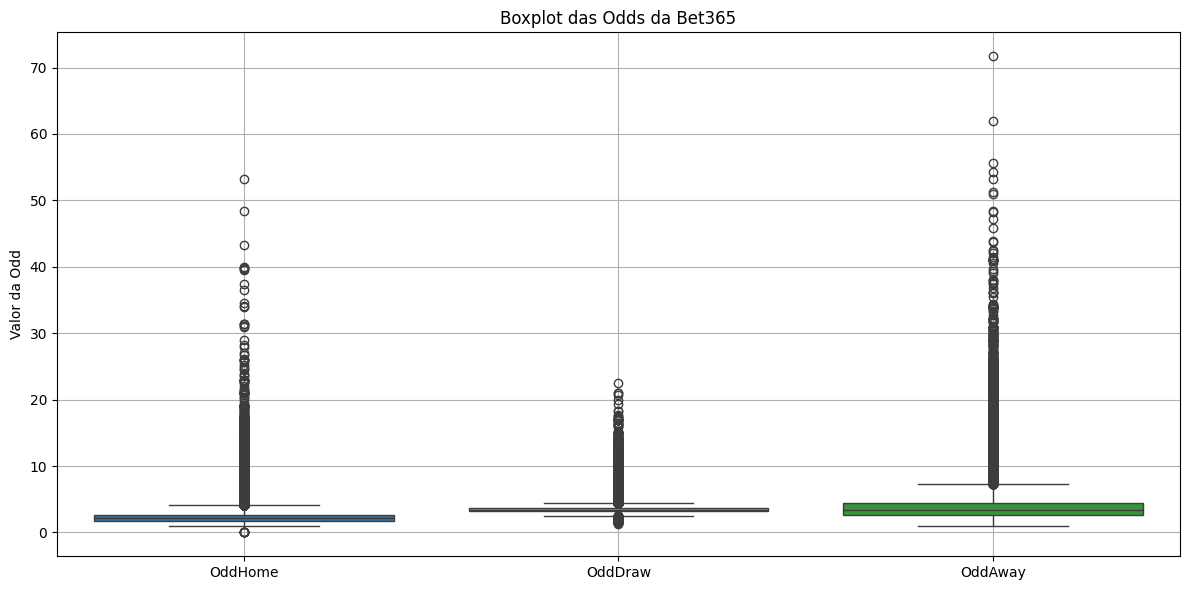

In [7]:
# Boxplot das odds da Bet365
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_reduzido[["OddHome", "OddDraw", "OddAway"]])
plt.title("Boxplot das Odds da Bet365")
plt.ylabel("Valor da Odd")
plt.grid(True)
plt.tight_layout()
plt.show()

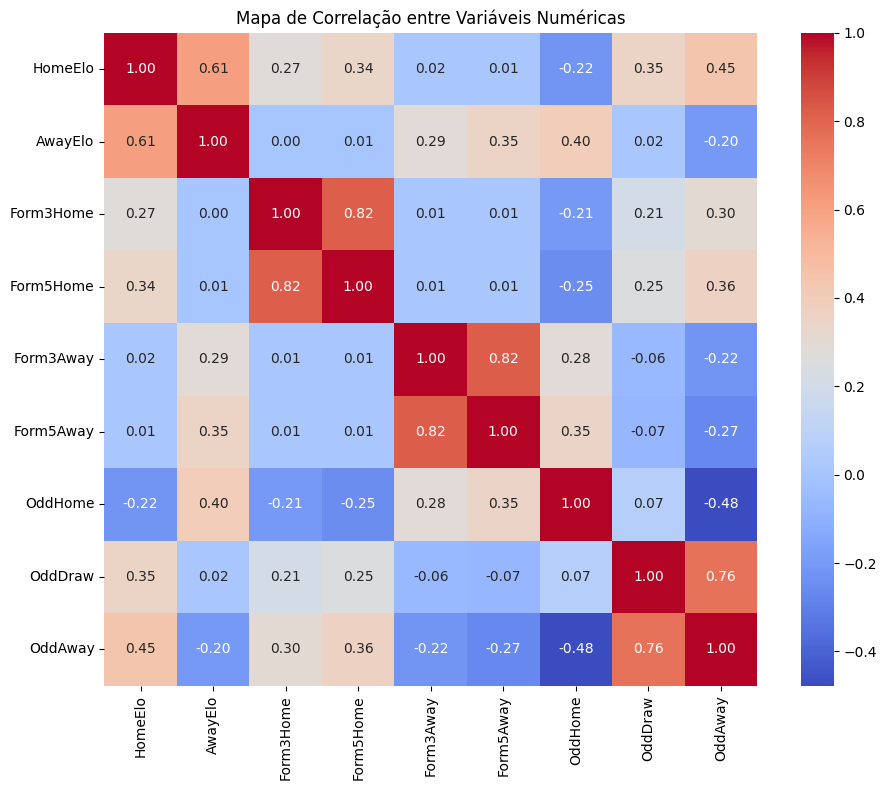

In [8]:
# Mapa de correlação
# Selecionar colunas numéricas
numeric_cols = df_reduzido.select_dtypes(include='number').columns

plt.figure(figsize=(10, 8))
sns.heatmap(df_reduzido[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Mapa de Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()

###REGRESSÃO LINEAR



In [12]:
# === Separar features e target ===
df_amostra = df_reduzido.sample(n=10000, random_state=42)
X = df_amostra.drop(columns=["OddHome", "OddDraw", "OddAway"])
y = df_amostra["OddHome"]

# Normalização e split
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Treinamento e avaliação
modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Métricas
resultados = {
    "MAE": mean_absolute_error(y_test, y_pred),
    "RMSE": mean_squared_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred)
}

# Exibir resultados
df_resultados = pd.DataFrame([resultados], index=["OddHome"])
print(df_resultados)


              MAE      RMSE        R²
OddHome  0.535222  0.862442  0.585738


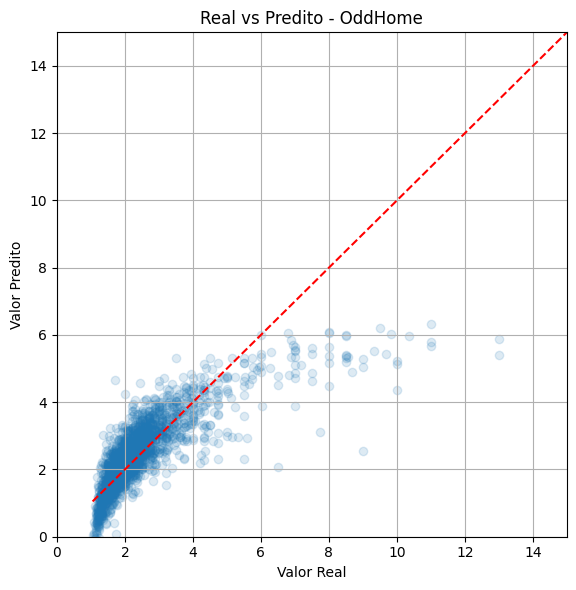

In [13]:
# Gráficos Real vs Predito

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.15)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Real vs Predito - OddHome")
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 15)
plt.xlim(0, 15)
plt.show()

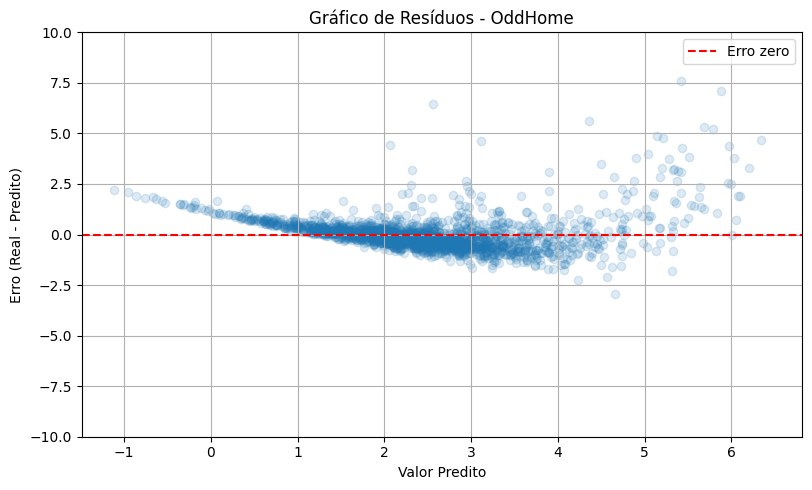

In [14]:
# === Função para gráfico de resíduos ===
def plot_residuos(y_real, y_pred, titulo):
    erros = y_real - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, erros, alpha=0.15)
    plt.axhline(y=0, color='red', linestyle='--', label='Erro zero')
    plt.xlabel("Valor Predito")
    plt.ylabel("Erro (Real - Predito)")
    plt.title(f"Gráfico de Resíduos - {titulo}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.ylim(-10,10)
    plt.show()

# === Gerar os gráficos ===
plot_residuos(y_test, y_pred, "OddHome")

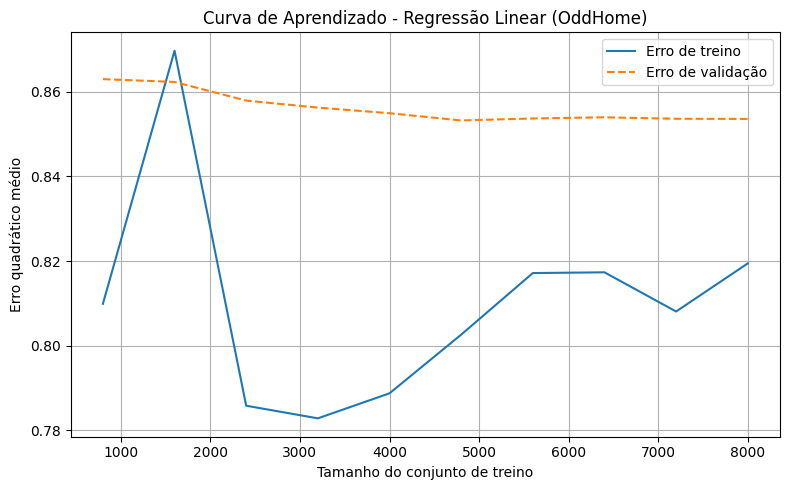

In [15]:
# Modelo
modelo = LinearRegression()

# Definir a estratégia de cross-validation
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Obter dados de curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(
    modelo, X_scaled, y, cv=cv, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calcular médias e desvios
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plotar
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Erro de treino")
plt.plot(train_sizes, test_scores_mean, label="Erro de validação", linestyle='--')
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("Erro quadrático médio")
plt.title("Curva de Aprendizado - Regressão Linear (OddHome)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###Random Forest

In [16]:
# === Separar features e target ===
df_amostra = df_reduzido.sample(n=10000, random_state=42)
X = df_amostra.drop(columns=["OddHome", "OddDraw", "OddAway"])
y = df_amostra["OddHome"]

# === Normalização ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Divisão treino/teste ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Definir modelo e grid de hiperparâmetros ===
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# === Treinamento com busca em grade ===
grid_search.fit(X_train, y_train)

# === Melhor modelo ===
melhor_rf = grid_search.best_estimator_
y_pred = melhor_rf.predict(X_test)

# === Avaliação ===
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest - OddHome")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print("Melhores hiperparâmetros:", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Forest - OddHome
MAE: 0.3721
RMSE: 0.4743
R²: 0.7722
Melhores hiperparâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


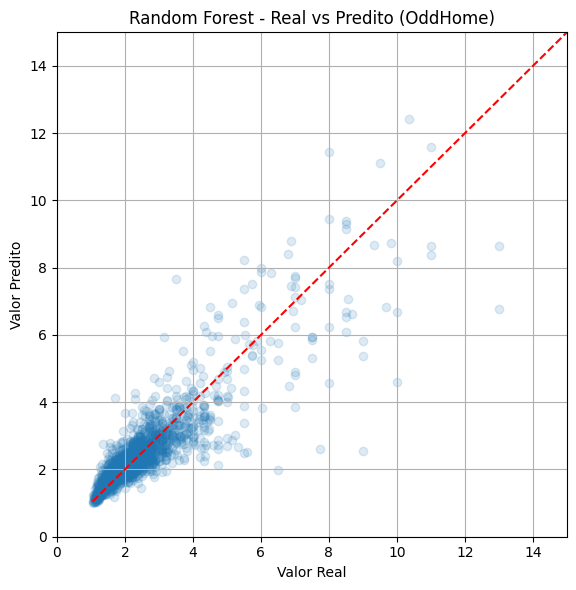

In [24]:
# === Gráfico Real vs Predito ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.15)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Random Forest - Real vs Predito (OddHome)")
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 15)
plt.xlim(0, 15)
plt.show()

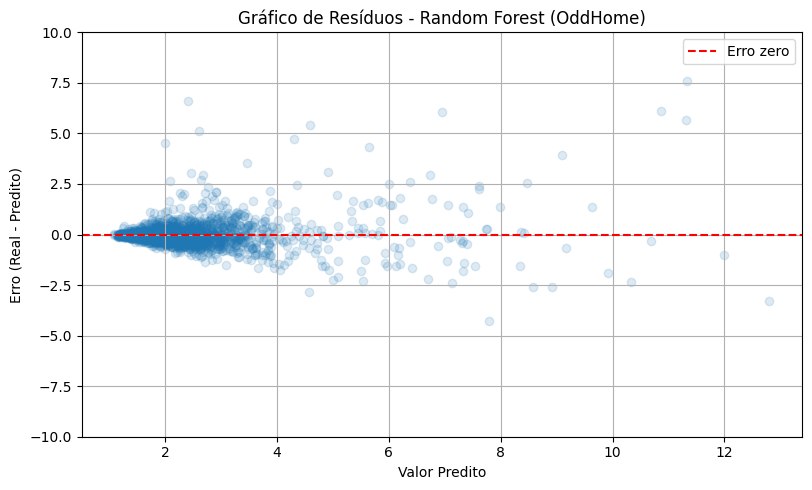

In [18]:
# === Gráfico de Resíduos ===
erros = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, erros, alpha=0.15)
plt.axhline(y=0, color='red', linestyle='--', label='Erro zero')
plt.xlabel("Valor Predito")
plt.ylabel("Erro (Real - Predito)")
plt.title("Gráfico de Resíduos - Random Forest (OddHome)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.ylim(-10,10)
plt.show()

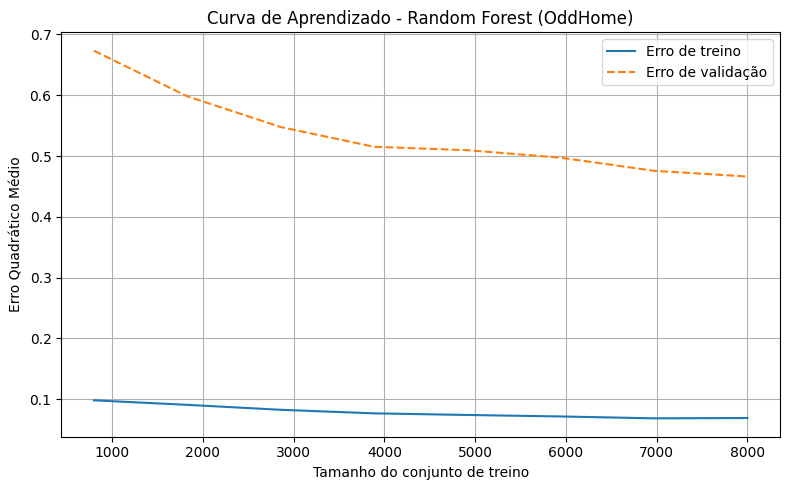

In [19]:
# === Estratégia de validação cruzada ===
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# === Obter dados da curva de aprendizado ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=melhor_rf,
    X=X_scaled,
    y=y,
    cv=cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

# === Calcular média dos erros (positivo) ===
train_errors_mean = -np.mean(train_scores, axis=1)
test_errors_mean = -np.mean(test_scores, axis=1)

# === Plotar curva de aprendizado ===
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors_mean, label="Erro de treino")
plt.plot(train_sizes, test_errors_mean, label="Erro de validação", linestyle='--')
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("Erro Quadrático Médio")
plt.title("Curva de Aprendizado - Random Forest (OddHome)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###XGBoost

In [25]:
# === Separar features e target ===
df_amostra = df_reduzido.sample(n=100000, random_state=42)
X = df_amostra.drop(columns=["OddHome", "OddDraw", "OddAway"])
y = df_amostra["OddHome"]


# === Normalização ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Divisão treino/teste ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Modelo e hiperparâmetros ===
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# === Treinamento ===
grid_search.fit(X_train, y_train)

# === Melhor modelo e avaliação ===
melhor_xgb = grid_search.best_estimator_
y_pred = melhor_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost - OddHome")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print("Melhores hiperparâmetros:", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
XGBoost - OddHome
MAE: 0.3370
RMSE: 0.4030
R²: 0.8021
Melhores hiperparâmetros: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


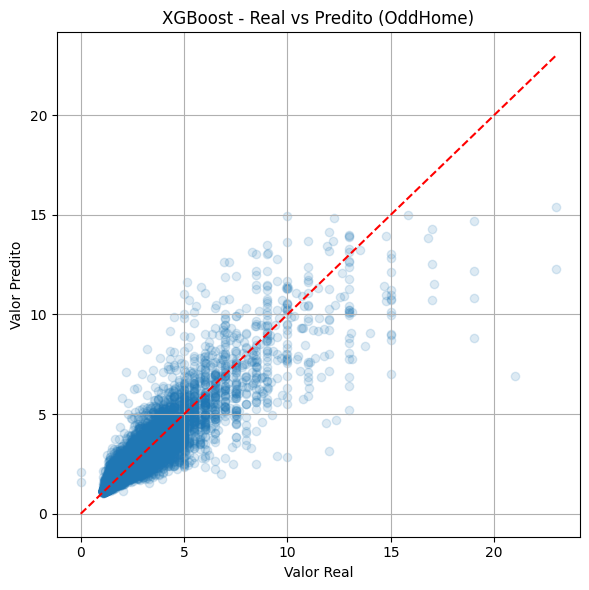

In [26]:
# === Gráfico Real vs Predito ===
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.15)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("XGBoost - Real vs Predito (OddHome)")
plt.grid(True)
plt.tight_layout()
plt.show()

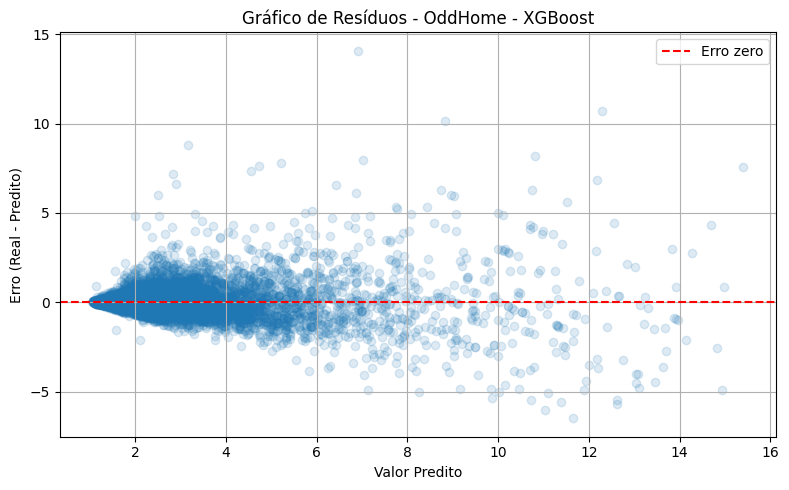

In [27]:
# === Função para gráfico de resíduos ===
def plot_residuos(y_real, y_pred, titulo):
    erros = y_real - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, erros, alpha=0.15)
    plt.axhline(y=0, color='red', linestyle='--', label='Erro zero')
    plt.xlabel("Valor Predito")
    plt.ylabel("Erro (Real - Predito)")
    plt.title(f"Gráfico de Resíduos - {titulo}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Gerar gráfico para OddHome ===
plot_residuos(y_test, y_pred, "OddHome - XGBoost")

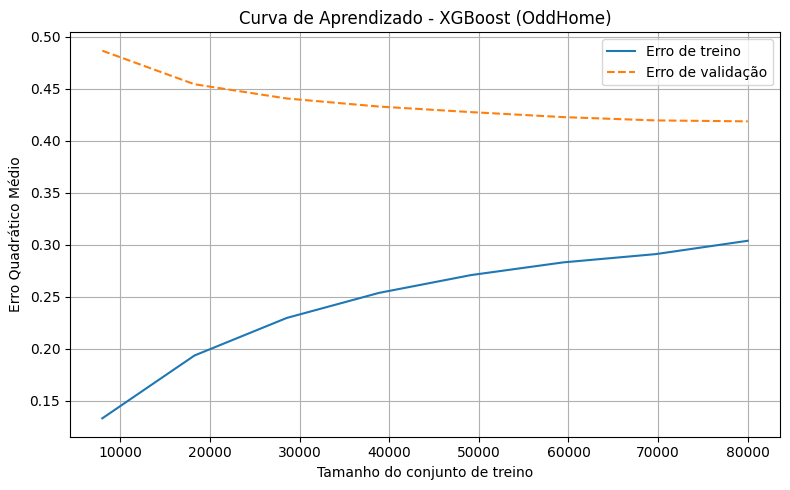

In [28]:
# Estratégia de validação
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(
    estimator=melhor_xgb,
    X=X_scaled,
    y=y,
    cv=cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

# Calcular erros médios
train_errors_mean = -np.mean(train_scores, axis=1)
test_errors_mean = -np.mean(test_scores, axis=1)

# Plotar curva de aprendizado
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors_mean, label="Erro de treino")
plt.plot(train_sizes, test_errors_mean, label="Erro de validação", linestyle='--')
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("Erro Quadrático Médio")
plt.title("Curva de Aprendizado - XGBoost (OddHome)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###PCA - XGBoost

In [29]:
from sklearn.decomposition import PCA
# === Separar features e target ===
X = df_reduzido.drop(columns=["OddHome", "OddDraw", "OddAway"])
y = df_reduzido["OddHome"]

# === Normalizar os dados ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Aplicar PCA (95% da variância explicada) ===
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# === Divisão treino/teste ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, _, _ = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [30]:
# Modelo XGBoost padrão
modelo_xgb = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# === Treinamento sem PCA ===
modelo_xgb.fit(X_train, y_train)
y_pred = modelo_xgb.predict(X_test)

# === Treinamento com PCA ===
modelo_xgb_pca = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
modelo_xgb_pca.fit(X_train_pca, y_train)
y_pred_pca = modelo_xgb_pca.predict(X_test_pca)

In [34]:
def avaliar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Avaliação
sem_pca = avaliar(y_test, y_pred)
com_pca = avaliar(y_test, y_pred_pca)

# Comparar resultados
df_resultado_pca = pd.DataFrame({
    "Sem PCA": sem_pca,
    "Com PCA (95%)": com_pca
}, index=["MAE", "RMSE", "R²"])

print(df_resultado_pca)

       Sem PCA  Com PCA (95%)
MAE   0.339535       0.427902
RMSE  0.415940       0.613407
R²    0.784779       0.682604


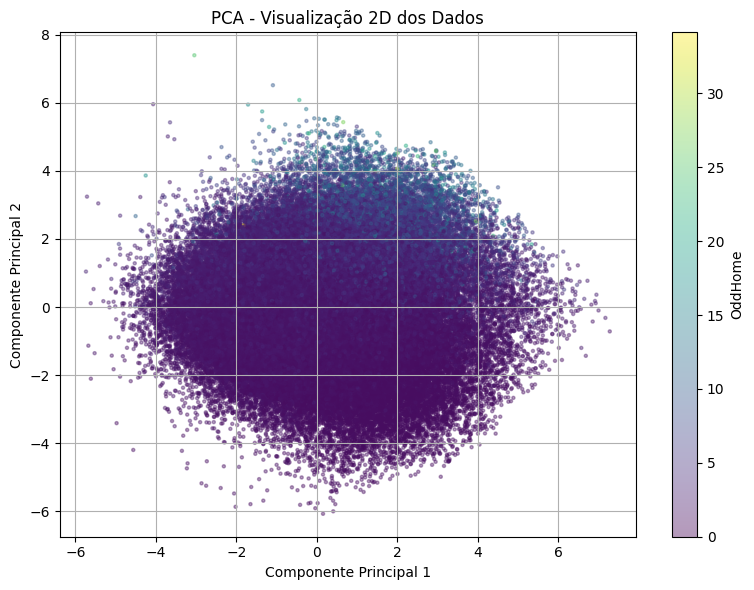

In [33]:
# PCA com 2 componentes apenas para visualização
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=y, cmap='viridis', s=5, alpha=0.4)
plt.colorbar(label="OddHome")
plt.title("PCA - Visualização 2D dos Dados")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()